# Empirically determine ratio of nucleus to cytosol diameter

In [1]:
from pathlib import Path
from typing import List
import h5py
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
import pandas as pd
from skimage.measure import regionprops, label
import seaborn as sns
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
seg_img_folder_A = Path("/vol/data/ttreis/projects/spatialdata-nik/snakemake/results/extraction")
seg_img_folder_B = Path("/vol/data/npeschke/spatialdata-nik/snakemake/results/extraction/source_2")

In [3]:
def find_h5_files(directory: Path) -> List[Path]:
    """
    Recursively finds all .h5 files in the specified directory.

    :param directory: Path object pointing to the directory where .h5 files are searched.
    :return: List of Path objects pointing to .h5 files found in the directory and its subdirectories.
    """
    if not directory.is_dir():
        raise ValueError(f"The provided path '{directory}' is not a valid directory.")

    # Use Path.rglob to find all .h5 files recursively
    return list(directory.rglob("*.h5"))

def count_total_cells(file_paths: List[Path]) -> int:
    """
    Counts the total number of cells across multiple HDF5 files.

    :param file_paths: List of Path objects pointing to HDF5 files.
    :return: Total number of cells across all provided HDF5 files.
    """
    total_cells = 0

    for file_path in file_paths:
        try:
            with h5py.File(file_path, "r") as file:
                if "single_cell_data" in file:
                    # The first dimension of the dataset indicates the number of cells
                    total_cells += file["single_cell_data"].shape[0]
                else:
                    print(f"Dataset 'single_cell_data' not found in file: {file_path}")
        except OSError:
            pass

    return total_cells

def display_single_channel(file_path: Path, cell_index: int, channel_index: int) -> None:
    """
    Displays a single channel of a specified cell from an HDF5 dataset.

    :param file_path: Path to the HDF5 file.
    :param cell_index: Index of the cell in the dataset.
    :param channel_index: Index of the channel to display.
    """
    with h5py.File(file_path, "r") as file:
        if "single_cell_data" in file:
            dataset = file["single_cell_data"]
            if cell_index < dataset.shape[0] and channel_index < dataset.shape[1]:
                image = dataset[cell_index, channel_index, :, :]
                plt.imshow(image, cmap="gray")
                plt.title(f"Cell {cell_index}, Channel {channel_index}")
                plt.show()
            else:
                print(f"Cell index or channel index is out of bounds.")
        else:
            print(f"Dataset 'single_cell_data' not found in file: {file_path}")
            
def calculate_diameters(file_path: Path) -> pd.DataFrame:
    """
    Calculates the diameters of the nucleus and cytosol for all cells in an HDF5 file.

    :param file_path: Path to the HDF5 file.
    :return: DataFrame with the diameters of the nucleus and cytosol for each cell.
    """
    results = []

    with h5py.File(file_path, "r") as file:
        if "single_cell_data" in file:
            dataset = file["single_cell_data"]

            for cell_index in range(dataset.shape[0]):
                # Extracting nucleus and cytosol images (assuming they are channels 0 and 1)
                nucleus_image = dataset[cell_index, 0, :, :]
                cytosol_image = dataset[cell_index, 1, :, :]

                # Calculating diameters
                nucleus_diameter = calculate_equivalent_diameter(nucleus_image)
                cytosol_diameter = calculate_equivalent_diameter(cytosol_image)

                results.append({
                    "cell_index": f"{file_path}_{cell_index}",
                    "cytosol": cytosol_diameter,
                    "nucleus": nucleus_diameter
                })

        else:
            print(f"Dataset 'single_cell_data' not found in file: {file_path}")

    return pd.DataFrame(results)

def calculate_equivalent_diameter(binary_image: np.array) -> float:
    """
    Calculate the equivalent diameter of the largest connected component in a binary image.

    :param binary_image: Binary image array.
    :return: Equivalent diameter of the largest connected component.
    """
    labeled_image = label(binary_image)
    regions = regionprops(labeled_image)

    if regions:
        # Find the largest region by area
        largest_region = max(regions, key=lambda r: r.area)
        return largest_region.equivalent_diameter
    else:
        return 0.0
    
def process_files_parallel(file_paths: list) -> pd.DataFrame:
    """
    Process a list of file paths in parallel and collect the results in a DataFrame.

    :param file_paths: List of file paths to process.
    :return: DataFrame with the combined results from all files.
    """
    results = []
    total_files = len(file_paths)
    completed_files = 0
    start_time = time.time()

    with ThreadPoolExecutor() as executor:
        # Create a future for each file
        futures = [executor.submit(calculate_diameters, file_path) for file_path in file_paths]

        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
                completed_files += 1

                # Print the progress at intervals of 5% since tqdm and parallel don't like each other
                if completed_files % max(1, total_files // 20) == 0 or completed_files == total_files:
                    elapsed_time = time.time() - start_time
                    print(f"Completed {completed_files}/{total_files} files ({(completed_files/total_files)*100:.2f}%) in {elapsed_time:.2f} seconds")

            except Exception as e:
                # print(f"An error occurred: {e}")
                pass

    # Concatenate all DataFrames into one
    return pd.concat(results, ignore_index=True)

def add_stats_annotation(ax, data, x_position, color):
    """Helper function to add statistics annotations on the plot."""
    mean = np.mean(data)
    std = np.std(data)
    textstr = f"Mean: {mean:.2f}\n" + \
              f"1σ: [{mean-std:.2f}, {mean+std:.2f}]\n" + \
              f"2σ: [{mean-2*std:.2f}, {mean+2*std:.2f}]\n" + \
              f"3σ: [{mean-3*std:.2f}, {mean+3*std:.2f}]"
    
    # Position the text relative to the violin plot
    props = dict(boxstyle="round", facecolor=color, alpha=0.5)
    ax.text(x_position, max(data)+10, textstr, fontsize=10, horizontalalignment="center", bbox=props)

## Preview of a single cell's segmentation results

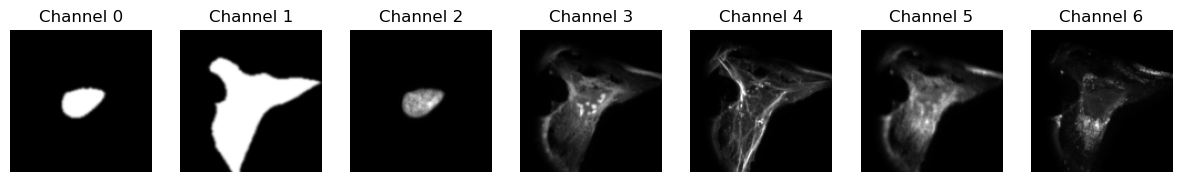

In [4]:
with h5py.File(find_h5_files(seg_img_folder_A)[3], "r") as file:

    plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

    for channel_index in range(7):
        image = file["single_cell_data"][0, channel_index, :, :]
        plt.subplot(1, 7, channel_index + 1)  # 1 row, 7 columns, subplot index
        plt.imshow(image, cmap="gray")
        plt.title(f"Channel {channel_index}")
        plt.axis('off')  # Turn off axis labels

    plt.show()

## Determine average diameter for nucleus and cytosol

In [5]:
all_files = find_h5_files(seg_img_folder_A) + find_h5_files(seg_img_folder_B)

measurements = process_files_parallel(all_files)

Completed 1150/23000 files (5.00%) in 567.05 seconds
Completed 2300/23000 files (10.00%) in 1049.02 seconds
Completed 3450/23000 files (15.00%) in 1498.54 seconds
Completed 4600/23000 files (20.00%) in 2017.26 seconds
Completed 5750/23000 files (25.00%) in 2333.31 seconds
Completed 6900/23000 files (30.00%) in 2783.04 seconds
Completed 8050/23000 files (35.00%) in 3253.60 seconds
Completed 9200/23000 files (40.00%) in 3697.83 seconds
Completed 10350/23000 files (45.00%) in 4205.00 seconds
Completed 11500/23000 files (50.00%) in 4696.28 seconds
Completed 12650/23000 files (55.00%) in 5178.18 seconds
Completed 13800/23000 files (60.00%) in 5677.75 seconds
Completed 14950/23000 files (65.00%) in 6108.26 seconds
Completed 16100/23000 files (70.00%) in 6641.65 seconds
Completed 17250/23000 files (75.00%) in 7169.33 seconds
Completed 18400/23000 files (80.00%) in 7761.20 seconds
Completed 19550/23000 files (85.00%) in 8348.76 seconds
Completed 20700/23000 files (90.00%) in 8917.32 seconds


/vol/data/ttreis/miniconda3/envs/snakemake/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/vol/data/ttreis/miniconda3/envs/snakemake/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


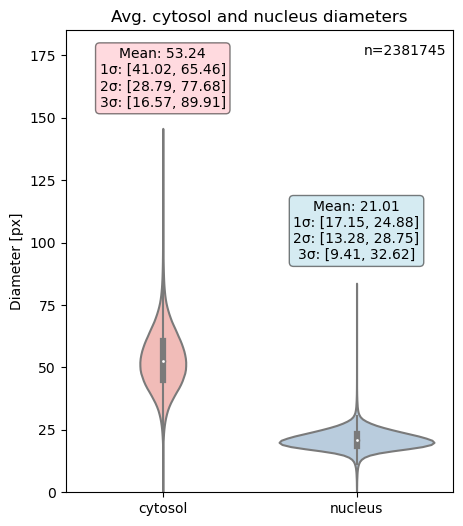

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(5, 6))
ax = sns.violinplot(data=measurements[["cytosol", "nucleus"]], palette="Pastel1")

add_stats_annotation(ax, measurements["cytosol"], 0, "lightpink")
add_stats_annotation(ax, measurements["nucleus"], 1, "lightblue")

plt.ylim(0, 185)
ax.text(1.25, 175, f"n={len(measurements)}", fontsize=10, horizontalalignment="center")
plt.title("Avg. cytosol and nucleus diameters")
plt.ylabel("Diameter [px]")
plt.show()
plt.savefig("./avg_diameter.png")